# Steam Game Price Prediction

# Abstract
This study aims to predict the discount prices of games on Steam, along with the rich metadata and user-generated tags associated with each game. The dataset comprises 71,700 entries, game titles, original and discounted prices, release dates, developer and publisher information, supported languages, popular user tags, game features, and minimum requirements. These entries are primarily textual and categorical, with numerical representations for prices. Our methodology involves preprocessing the data, including handling missing values and transforming user-generated tags into one-hot encoded vectors to quantify the categorical data effectively. We will explore the dataset through exploratory data analysis (EDA) to uncover underlying patterns and relationships. The study will then apply clustering techniques, specifically DBSCAN, Spectral Clustering, and Gaussian Mixture Models (GMM), to group games based on their tags and features. This clustering will serve as a foundation for predicting game discount prices. The performance of our price prediction model will be evaluated using the Mean Absolute Error (MAE), while the effectiveness of our clustering approach will be assessed using the Adjusted Rand Index (ARI), ensuring a comprehensive evaluation of both the accuracy of price predictions and the quality of game groupings.

# Background

The exponential growth of the computer gaming industry into a multi-billion dollar industry shows its widespread popularity and economic significance. However, the industry faces unique challenges, such as the difficulty in satisfying a multicultural player base. Research indicates that implementing discount strategies is a crucial business tactic for bringing up sales in the competitive market. <a name="dunote"></a>[<sup>[1]</sup>](#dunote)Previous studies have focused on predicting the timing of discounts for games, leveraging historical data to predict when price reductions are likely to occur.<a name="linnote"></a>[<sup>[2]</sup>](#linnote) Building on this foundation, our research aims to predict not just the timing but the specific discount rates of computer games on steam.

# Problem Statement
We are aiming to predict the discount price of games in Steam. Games in steam are all labeled with tags and features, which makes it perfect for clustering algorithms. Though tags are generated by users, we can still transform it into one-hot encoding for it to be quantifiable. Measuring should be easy as we can use accuracy for predict prices, or use distance for clustering performance. We will use fixed seed to ensure the algorithm is replicable.

# Data
We will be using the [Steam Games Dataset](https://www.kaggle.com/datasets/nikatomashvili/steam-games-dataset) from Kaggle. It has 71000 game data points, with around 15 variables, including `Price`, `Review Rate`, `Release Date`, `Tag`,.etc.

In [85]:
import pandas as pd
df = pd.read_csv('Steam_Game_Dataset.csv')

Here's what an observation consist of:

In [86]:
df.columns

Index(['Title', 'Original Price', 'Discounted Price', 'Release Date', 'Link',
       'Game Description', 'Recent Reviews Summary', 'All Reviews Summary',
       'Recent Reviews Number', 'All Reviews Number', 'Developer', 'Publisher',
       'Supported Languages', 'Popular Tags', 'Game Features',
       'Minimum Requirements'],
      dtype='object')

In [87]:
print(df.iloc[0].iloc[13]) # Tag
print(df.iloc[0].iloc[14]) # Game Features

['RPG', 'Choices Matter', 'Character Customization', 'Story Rich', 'Adventure', 'Online Co-Op', 'CRPG', 'Multiplayer', 'Fantasy', 'Turn-Based Combat', 'Dungeons & Dragons', 'Co-op Campaign', 'Strategy', 'Singleplayer', 'Romance', 'Class-Based', 'Dark Fantasy', 'Combat', 'Controller', 'Stealth']
['Single-player', 'Online Co-op', 'LAN Co-op', 'Steam Achievements', 'Full controller support', 'Steam Cloud']


The dataset was obtained via web-crawling, which is very raw and contains garbled characters. We need a lot of pre-processing to clean and prune the dataset so it is usable. Also, some features are presented with list, so we need a `dict` and remap it into one-hot encoding for ML.

# Data Pre-processing

Remove unused columns.

In [88]:
df.drop(columns=['Title','Game Description', 'Developer', 'Publisher', 'Minimum Requirements'],inplace=True)

In [ ]:
#Clean prices
df['Original Price'] = pd.to_numeric(df['Original Price'].replace({'\$': '',',':''}, regex=True).replace({'Free': '0'}))
df['Discounted Price'] = pd.to_numeric(df['Discounted Price'].replace({'\$': '',',':''}, regex=True).replace({'Free': '0'}))

Change game names to unique `GameID`s.

In [90]:
#Clean gameID
df['GameID'] = df['Link'].str.extract(r'(app|sub)/(\d+)/')[1]
df.drop(columns=['Link'],inplace=True)

Change `Release Date` into `datetime` format.

In [91]:
def parse_date(date_str):
    try:
        return pd.to_datetime(date_str, format='%d %b, %Y')
    except ValueError:
        return pd.NaT

# Apply the function to the 'Release Date' column
df['Release Date 2'] = df['Release Date'].apply(parse_date)

In [92]:
rows_to_update = df[df['Release Date 2'].isna()]

# Define a format string that matches your date format
date_format = "%b %Y"

# Update the 'Release Date 2' column with the re-extracted datetime values
df.loc[rows_to_update.index, 'Release Date 2'] = pd.to_datetime(rows_to_update['Release Date'], format=date_format, errors= 'coerce')

In [93]:
rows_to_update = df[df['Release Date 2'].isna()]

# Define a format string that matches your date format
date_format = "%B %Y"

# Update the 'Release Date 2' column with the re-extracted datetime values
df.loc[rows_to_update.index, 'Release Date 2'] = pd.to_datetime(rows_to_update['Release Date'], format=date_format, errors= 'coerce')

Check to see what are the non-`datetime` entries.

In [94]:
df[df['Release Date 2'].isna()]["Release Date"].unique()

array([nan, 'Coming soon', 'To be announced', '2023', 'Q3 2023',
       'Q2 2024', '2024', 'Q1 2024', '2025', 'Q1 2025', 'Q4 2023',
       'Q4 2024', 'Q3 2024', '2026', 'Q2 2025', 'Maybe', 'Q3 2032',
       '3 Apr, 4444', 'Q4 2025', '2030', 'Coming Soon', '2027', 'Q3 2020',
       '9 Jun, 6969'], dtype=object)

In [95]:
df[df['Release Date 2'].isna()]["Release Date"].isna().sum()

131

Looks like most of them are just games waiting to be released. There is about 9800 of them, which is not a small proportion of the dataset. Only 131 games are ones with `NaT`, we will drop these games. For future released games, we will set their release date to be `2025-01-01`.

In [96]:
df = df.dropna(subset=['Release Date'])

nan_rows = df['Release Date 2'].isna()

df.loc[nan_rows, 'Release Date 2'] = pd.to_datetime("2025-01-01")

df['Release Date'] = df['Release Date 2']

df.drop(columns=["Release Date 2"],inplace=True)

Reshaping `Review Summary` columns into numeric categories.


| Category                  | Value  |
|---------------------------|--------|
| Overwhelmingly Positive   | 2      |
| Very Positive             | 1.5    |
| Positive                  | 1      |
| Mostly Positive           | 0.5    |
| Mixed / Not enough reviews| 0      |
| Mostly Negative           | -0.5   |
| Negative                  | -1     |
| Very Negative             | -1.5   |
| Overwhelmingly Negative   | -2     |


In [ ]:
#Reshape reviews
category_mapping = {
    'Overwhelmingly Positive': 2,
    'Very Positive': 1.5,
    'Positive': 1,
    'Mostly Positive': 0.5,

    'Mixed': 0,
    '1 user reviews': 0,
    '2 user reviews': 0,
    '3 user reviews': 0,
    '4 user reviews': 0,
    '5 user reviews': 0,
    '6 user reviews': 0,
    '7 user reviews': 0,
    '8 user reviews': 0,
    '9 user reviews': 0,

    'Mostly Negative': -0.5,
    'Negative': -1,
    'Very Negative': -1.5,
    'Overwhelmingly Negative': -2
}

# Replace values in the 'YourColumn' column
df['Recent Reviews Summary'] = df['Recent Reviews Summary'].replace(category_mapping)
df['All Reviews Summary'] = df['All Reviews Summary'].replace(category_mapping)


In [98]:
numeric_values = df['Recent Reviews Number'].str.extract(r'(\d+,\d+) user reviews')[0].str.replace(',', '')
numeric_values = pd.to_numeric(numeric_values, errors='coerce').fillna(0).astype(int)
percentage_values = df['Recent Reviews Number'].str.extract(r'(\d+)%')[0].astype(float) / 100

df['Recent Reviews'] = numeric_values
df['Recent Positive Ratio'] = percentage_values

numeric_values = df['All Reviews Number'].str.extract(r'(\d+,\d+) user reviews')[0].str.replace(',', '')
numeric_values = pd.to_numeric(numeric_values, errors='coerce').fillna(0).astype(int)
percentage_values = df['All Reviews Number'].str.extract(r'(\d+)%')[0].astype(float) / 100

df['Reviews Total'] = numeric_values
df['Positive Ratio Total'] = percentage_values

df.drop(columns=['Recent Reviews Number','All Reviews Number'], inplace=True)


Reshape `Language Support` into a one-hot encoder.

In [99]:
from sklearn.preprocessing import MultiLabelBinarizer
import ast

df['Supported Languages'] = df['Supported Languages'].apply(ast.literal_eval)

# Use MultiLabelBinarizer to create one-hot encoding
mlb = MultiLabelBinarizer()
one_hot_encoded_languages = pd.DataFrame(mlb.fit_transform(df['Supported Languages']), columns=mlb.classes_, index=df.index)

columns_to_drop = ["#lang_#lang_russian*#lang_full_audio",
                   "#lang_#lang_spanish*#lang_full_audio",
                   "#lang_english (full audio)",
                   "(all with full audio support)",
                   "#lang_german;",
                   "#lang_slovakian"]

columns_to_drop = [col for col in columns_to_drop if col in one_hot_encoded_languages.columns]
one_hot_encoded_languages.drop(columns=columns_to_drop, inplace=True)


In [100]:
df = pd.concat([df, one_hot_encoded_languages], axis=1)
df['OneHot Encoded Languages'] = df.apply(lambda row: row[one_hot_encoded_languages.columns].tolist(), axis=1)

df.drop(columns=one_hot_encoded_languages.columns, inplace=True)
df.drop(columns=['Supported Languages'], inplace=True)

Reshape `Popular Tags` into a one-hot encoder.

In [101]:
df['Popular Tags'] = df['Popular Tags'].apply(ast.literal_eval)

# Use MultiLabelBinarizer to create one-hot encoding
mlb = MultiLabelBinarizer()
one_hot_encoded_tags = pd.DataFrame(mlb.fit_transform(df['Popular Tags']), columns=mlb.classes_, index=df.index)

df = pd.concat([df, one_hot_encoded_tags], axis=1)
df['OneHot Encoded Tags'] = df.apply(lambda row: row[one_hot_encoded_tags.columns].tolist(), axis=1)

df.drop(columns=one_hot_encoded_tags.columns, inplace=True)
df.drop(columns=['Popular Tags'], inplace=True)

Reshape `Game Features` into a one-hot encoder.

In [102]:
df['Game Features'] = df['Game Features'].apply(ast.literal_eval)

# Use MultiLabelBinarizer to create one-hot encoding
mlb = MultiLabelBinarizer()
one_hot_encoded_features = pd.DataFrame(mlb.fit_transform(df['Game Features']), columns=mlb.classes_, index=df.index)

df = pd.concat([df, one_hot_encoded_features], axis=1)
df['OneHot Encoded Features'] = df.apply(lambda row: row[one_hot_encoded_features.columns].tolist(), axis=1)

df.drop(columns=one_hot_encoded_features.columns, inplace=True)
df.drop(columns=['Game Features'], inplace=True)

Reordering columns for better reading experience.

In [103]:
df = df[['GameID','Release Date','Original Price', 'Discounted Price',
       'Recent Reviews', 'Recent Positive Ratio',
       'Reviews Total', 'Positive Ratio Total',
       'OneHot Encoded Languages', 'OneHot Encoded Tags',
       'OneHot Encoded Features']]

Some games do not have recent reviews, or just have no reviews at all. Replacing these with zero.

In [104]:
na_to_zero_cols = ['Recent Reviews', 'Recent Positive Ratio', 'Reviews Total', 'Positive Ratio Total',]
df[na_to_zero_cols] = df[na_to_zero_cols].fillna(0)

Cleaned dataset:

In [105]:
df.head()

,GameID,Release Date,Original Price,Discounted Price,Recent Reviews,Recent Positive Ratio,Reviews Total,Positive Ratio Total,OneHot Encoded Languages,OneHot Encoded Tags,OneHot Encoded Features
0,1086940,2023-08-03,29.99,29.99,128900,0.96,188617,0.94,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, ..."
1,730,2012-08-21,14.99,14.99,75284,0.89,428921,0.88,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,1172470,2020-11-04,0.00,0.00,18581,0.65,701597,0.80,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, ..."
3,1551360,2021-11-08,34.78,17.39,4120,0.87,123162,0.88,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
4,1938090,2022-10-27,0.00,0.00,8257,0.49,236876,0.57,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, ..."


# Data Analysis

The Prices both before and after discount was heavily skewed to the right, leading the conclusion that most of the games were priced at the lower end of the price range. There were peaks at 0 price, indicating free games.

In [106]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
import numpy as np

sns.set_theme(style = "whitegrid")

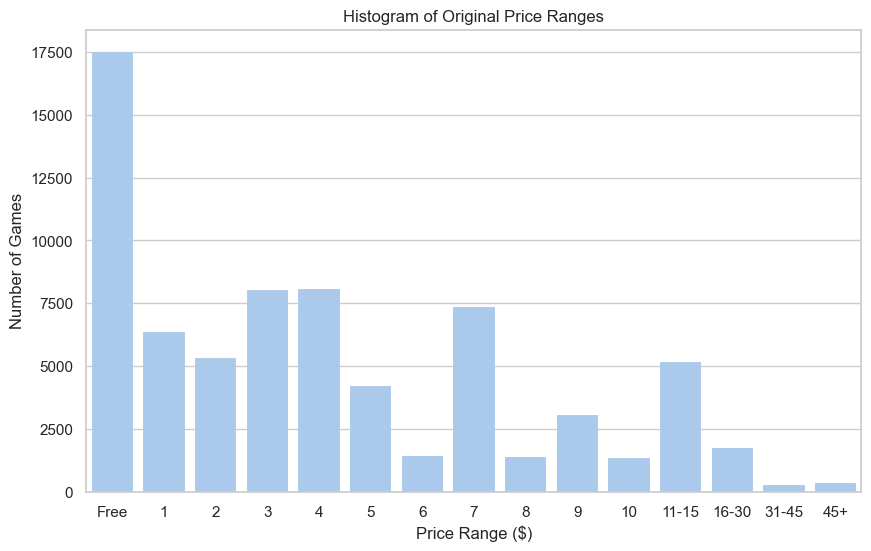

In [107]:
df['Price Range'] = pd.cut(df['Original Price'],
                           bins=[-0.01, 0.01, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 30, 45, float('inf')],
                           right=False,
                           labels=['Free', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11-15', '16-30', '31-45', '45+'])

plt.figure(figsize=(10, 6))
sns.set_palette(['#a1c9f4'])
sns.countplot(data=df, x='Price Range', order=['Free', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11-15', '16-30', '31-45', '45+'], linewidth=0.1)
plt.title('Histogram of Original Price Ranges')
plt.xlabel('Price Range ($)')
plt.ylabel('Number of Games')
plt.show()

From the heatmap we can see there was no significant relations between language supported and positive review. The strong positive correlation of 1.00 between these two variables implies that games with higher original prices also tend to have higher discounted prices, which is what we were expected.

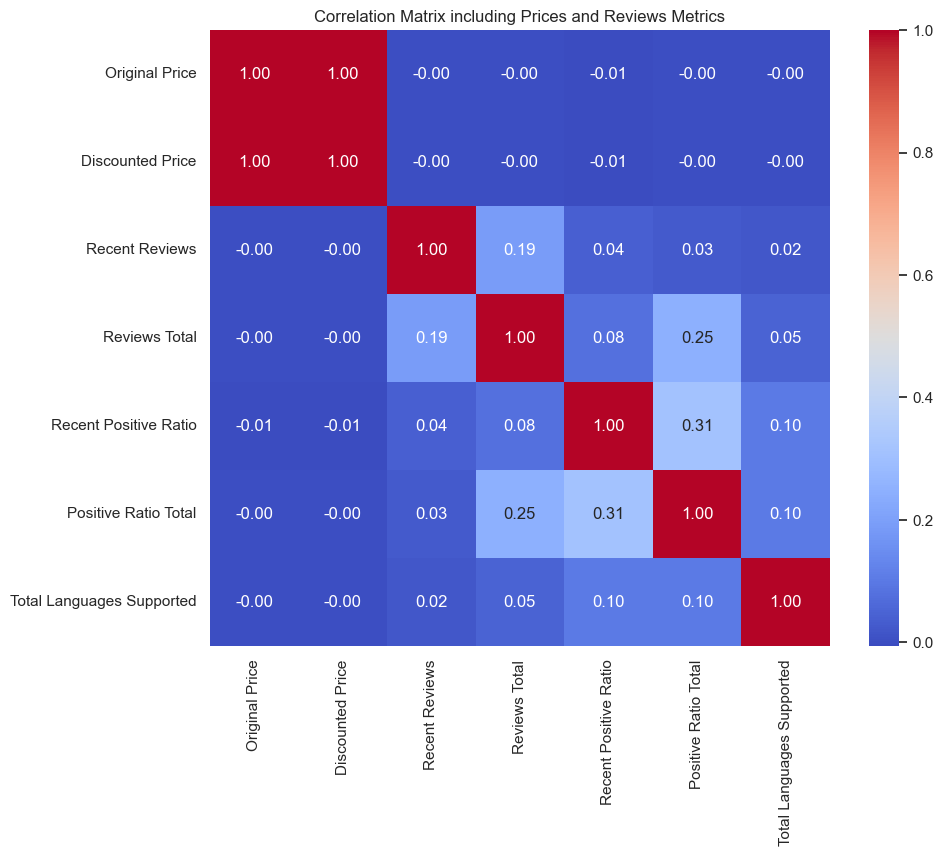

In [108]:
df['Total Languages Supported'] = df['OneHot Encoded Languages'].apply(lambda x: sum(x))

variables_for_correlation = [
    'Original Price', 'Discounted Price', 'Recent Reviews',
    'Reviews Total', 'Recent Positive Ratio', 'Positive Ratio Total',
    'Total Languages Supported'
]

correlation_matrix = df[variables_for_correlation].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix including Prices and Reviews Metrics')
plt.show()

# PCA

In [33]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

Make the values into scale for PCA. Since PCA does not perform well in high dimensions, we temporally discard the `tag` columns.

In [26]:
df_PCA = df[['Original Price', 'Discounted Price',
       'Recent Reviews', 'Recent Positive Ratio', 'Reviews Total',
       'Positive Ratio Total', 'Total Languages Supported']]

scaler = StandardScaler()
scaled = scaler.fit_transform(df_PCA)

scaled_df = pd.DataFrame(scaled, columns=scaler.get_feature_names_out())
scaled_df.head()

,Original Price,Discounted Price,Recent Reviews,Recent Positive Ratio,Reviews Total,Positive Ratio Total,Total Languages Supported
0,-0.006218,-0.005589,100.632650,1.379713,13.535480,3.879579,0.786225
1,-0.006383,-0.006139,58.758125,1.206773,30.868576,3.613956,2.179605
2,-0.006548,-0.006688,14.472628,0.613837,50.536660,3.259791,0.879117
3,-0.006165,-0.006051,3.178471,1.157362,8.814220,3.613956,1.064901
4,-0.006548,-0.006688,6.409501,0.218546,17.016395,2.241566,0.879117


In [27]:
pca = PCA(n_components=2)
reduced = pca.fit_transform(scaled_df) 

reduced_df = pd.DataFrame(reduced, columns=['pc1','pc2'])

reduced_df['Price Range'] = df['Price Range']

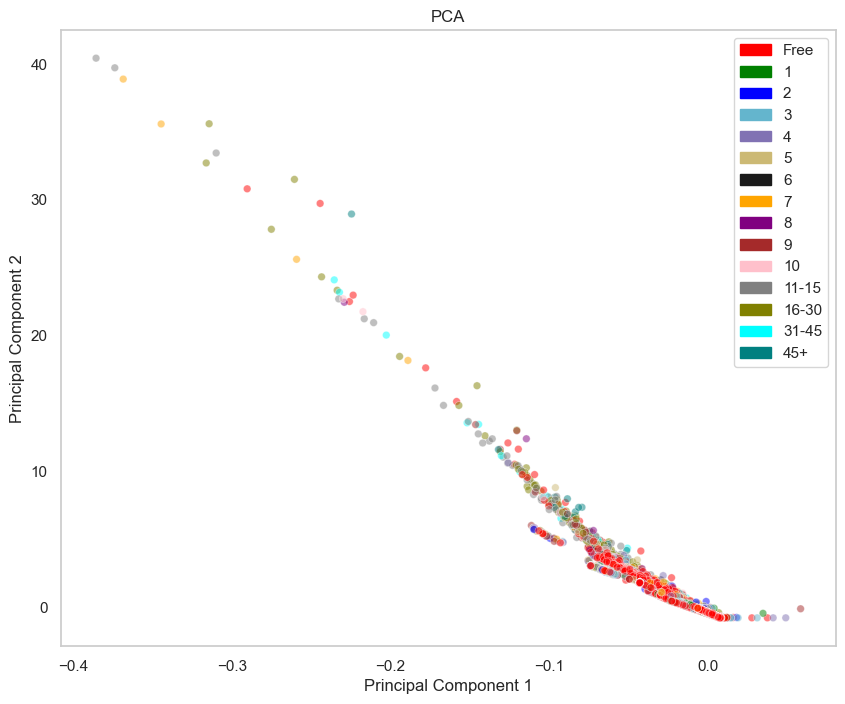

In [28]:
reduced_df = reduced_df[reduced_df['pc1'] <= 0.2]

targets = ['Free', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11-15', '16-30', '31-45', '45+']
colors = ['red', 'green', 'blue', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 'teal']

target_color_dict = dict(zip(targets, colors))
plt.figure(figsize=(10, 8))

sns.scatterplot(data=reduced_df, x='pc1', y='pc2', hue='Price Range', palette=target_color_dict, alpha=0.5, s=30)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA')
# plt.legend(labels=targets)
handles = [plt.Rectangle((0,0),1,1, color=target_color_dict[label]) for label in targets];
plt.legend(handles, targets, loc='upper right')
plt.grid()
plt.show()

Can't tell much from the result. This is expected because the data has noise and outliers. Some hot games are free, while some are not .etc. We will try to find how many components is needed for PCA to distinguish this dataset.

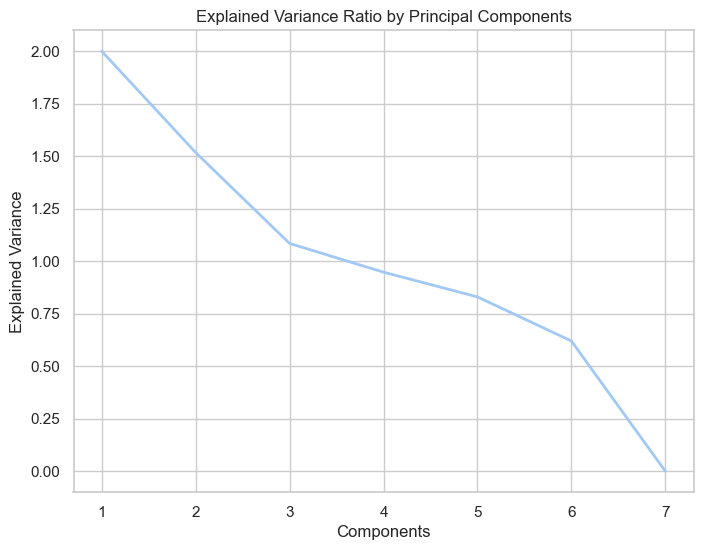

In [29]:
pca2 = PCA().fit(scaled_df)

# Convert explained variance to a DataFrame
explained_variance_df = pd.DataFrame({'Components': range(1, len(pca2.explained_variance_) + 1),
                                     'Explained Variance': pca2.explained_variance_})

# Plot using seaborn
plt.figure(figsize=(8, 6))
sns.lineplot(data=explained_variance_df, x='Components', y='Explained Variance', linewidth=2)
plt.xlabel('Components')
plt.ylabel('Explained Variance')
plt.title('Explained Variance Ratio by Principal Components')
plt.show()

In [31]:
# Perform PCA with chosen components
pca_opt = PCA(n_components = 4)
scores = pca.fit_transform(scaled_df)

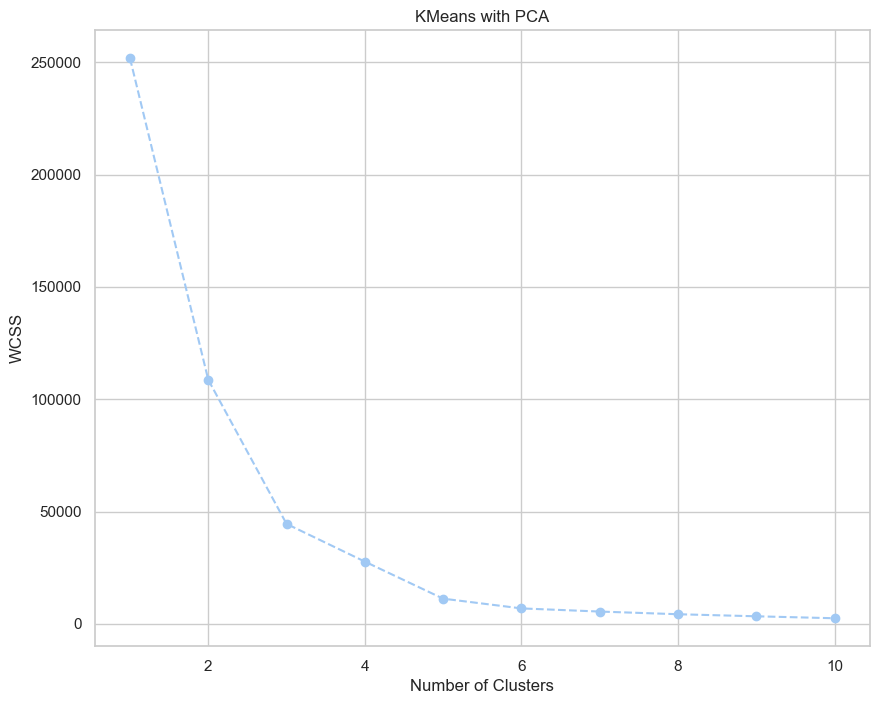

In [34]:
# Fit K-Means
wcss = []
for i in range(1,11):
    kmeans_pca = KMeans(n_clusters = i, init ='k-means++', random_state = 42)
    kmeans_pca.fit(scores)
    wcss.append(kmeans_pca.inertia_)
    
plt.figure(figsize = (10,8))
plt.plot(range(1,11), wcss, marker = 'o', linestyle = '--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('KMeans with PCA')
plt.show()

From this graph, we determine the number of clusters by using elbow method. We could see the elbow point is around 3, and thus 3 clusters.

# UMAP

In [37]:
import umap

Process onehot columns

In [38]:
one_hot_languages = pd.DataFrame(df['OneHot Encoded Languages'].tolist(), index=df.index)
one_hot_languages.columns = ['Language_' + str(i) for i in range(one_hot_languages.shape[1])]

one_hot_tags = pd.DataFrame(df['OneHot Encoded Tags'].tolist(), index=df.index)
one_hot_tags.columns = ['Tag_' + str(i) for i in range(one_hot_tags.shape[1])]

one_hot_fea = pd.DataFrame(df['OneHot Encoded Features'].tolist(), index=df.index)
one_hot_fea.columns = ['Feature_' + str(i) for i in range(one_hot_fea.shape[1])]

In [39]:
# Drop irrelevant columns
X_UMAP = df.drop(['GameID','Release Date','Discounted Price','OneHot Encoded Languages','OneHot Encoded Tags','OneHot Encoded Features'], axis = 1)
# Add the processed onehot columns
X_UMAP = pd.concat([X_UMAP, one_hot_languages, one_hot_tags, one_hot_fea], axis = 1)
X_UMAP

,Original Price,Recent Reviews,Recent Positive Ratio,Reviews Total,Positive Ratio Total,Price Range,Total Languages Supported,Language_0,Language_1,Language_2,...,Feature_26,Feature_27,Feature_28,Feature_29,Feature_30,Feature_31,Feature_32,Feature_33,Feature_34,Feature_35
0,29.99,128900,0.96,188617,0.94,16-30,13,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,14.99,75284,0.89,428921,0.88,11-15,28,0,0,0,...,0,0,1,0,1,0,0,0,0,1
2,0.00,18581,0.65,701597,0.80,Free,14,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,34.78,4120,0.87,123162,0.88,31-45,16,0,0,0,...,1,0,1,0,0,0,0,0,0,0
4,0.00,8257,0.49,236876,0.57,Free,14,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71695,0.00,0,0.00,0,0.00,Free,10,0,0,0,...,0,0,0,0,1,0,0,0,0,0
71696,0.00,0,0.00,0,0.00,Free,15,0,0,0,...,0,0,0,0,0,0,0,0,0,0
71697,0.00,0,0.00,0,0.00,Free,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
71698,69.99,0,0.00,0,0.00,45+,15,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
#Standardize X_UMAP
def convert_range_to_midpoint(value):
    if '-' in str(value):
        low, high = map(float, value.split('-'))
        return (low + high) / 2
    elif '+' in str(value):
        return float(value.rstrip('+'))
    elif str(value) == 'Free':
        return 0
    else:
        return float(value)
    
X_UMAP['Price Range'] = X_UMAP['Price Range'].apply(convert_range_to_midpoint)
X_UMAP = X_UMAP.dropna()

scaler = StandardScaler()
X_UMAP_scaled = scaler.fit_transform(X_UMAP)

Apply UMAP

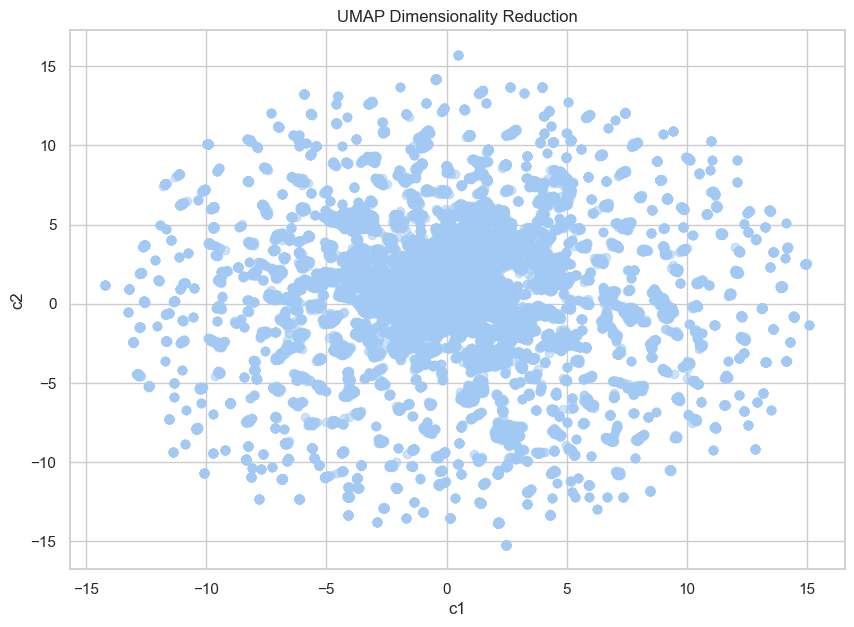

In [42]:
import matplotlib.pyplot as plt

umap_5 = umap.UMAP(n_neighbors=5, min_dist=0.1, metric='euclidean')
ucs = umap_5.fit_transform(X_UMAP_scaled)

def plot_components(data, component1, component2):
    plt.figure(figsize=(10, 7))
    plt.scatter(data[component1], data[component2], alpha=0.5)
    plt.xlabel(component1)
    plt.ylabel(component2)
    plt.title('UMAP Dimensionality Reduction')
    plt.show()

ucs = pd.DataFrame(ucs,columns=['c1','c2'])
ucs.index = X_UMAP.index
plot_components(ucs,'c1','c2')

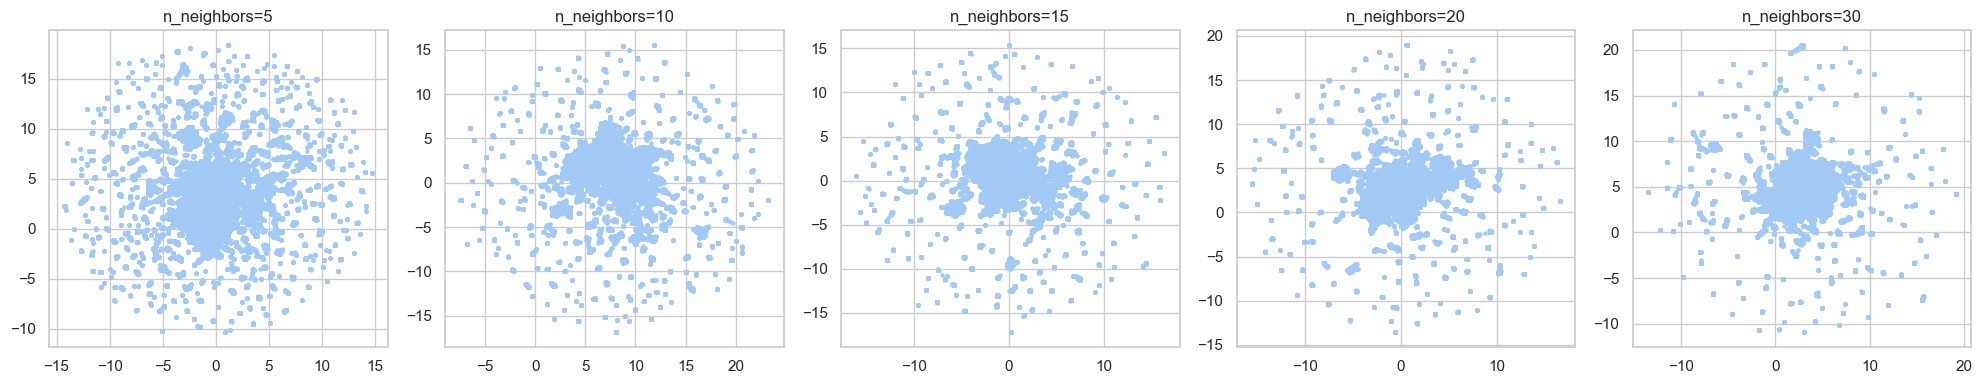

In [43]:
# List of parameters to try
values_of_n_neighbors = [5,10,15,20,30]
fig, axs = plt.subplots(1, len(values_of_n_neighbors), figsize=(20, 4))

# Plot UMAP plots to visualize local and global structures
for i, n in enumerate(values_of_n_neighbors):
    reducer = umap.UMAP(n_neighbors=n, n_components=2, random_state=99)
    embedding = reducer.fit_transform(X_UMAP_scaled)
    axs[i].scatter(embedding[:, 0], embedding[:, 1], s=5)
    axs[i].set_title(f'n_neighbors={n}')
plt.tight_layout()

# Clustering

When DBSCAN was applied with an eps value of 7, the algorithm identified 4 distinct clusters within the dataset, but a significant majority of data points, specifically 4023 out of 4069, were categorized as noise. This clustering outcome indicates that while the data does possess some cluster structure, the eps value chosen is not optimal for capturing the majority of the data points within meaningful clusters. The high number of noise points suggests that the data points are sparsely distributed, with only a few dense regions that DBSCAN can identify as clusters.

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler


# Combine all the one-hot encoded features into one DataFrame
df_extended = pd.concat([df, one_hot_languages, one_hot_tags, one_hot_fea], axis=1)
one_hot_features = pd.concat([pd.DataFrame(df['OneHot Encoded Languages'].tolist()),
                              pd.DataFrame(df['OneHot Encoded Tags'].tolist()),
                              pd.DataFrame(df['OneHot Encoded Features'].tolist())], axis=1)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(one_hot_features)

# Apply DBSCAN
db = DBSCAN(eps=7, min_samples=5).fit(X_scaled)

# Retrieve the labels_
labels = db.labels_

# Number of clusters in labels
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)



Estimated number of clusters: 4
Estimated number of noise points: 4023
Silhouette Score: 0.7007


Spectral clustering was applied with an initial guess of three clusters, which resulted in a silhouette score of approximately -0.0148. This score, which ranges from -1 to 1, with higher values indicating better-defined clusters, suggests that the clusters are overlapping and not well-separated from each other. The negative silhouette score indicates that on average, data points are closer to members of other clusters than to members of their own cluster. This outcome could imply that the number of clusters chosen was not suitable or that the dataset does not have a clear cluster structure as defined by the features provided for spectral clustering.

In [ ]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score

n_clusters = 3

# Apply Spectral Clustering
spectral_model = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42)
labels_spectral = spectral_model.fit_predict(X_scaled)


# Evaluate the cluster performance using silhouette score
silhouette_avg = silhouette_score(X_scaled, labels_spectral)
print('Silhouette Score for Spectral Clustering:', silhouette_avg)


Silhouette Score for Spectral Clustering: -0.03506217018141109


The application of Gaussian Mixture Models to the dataset yielded a silhouette score of approximately 0.1409. suggests that the clusters are moderately defined, with some level of separation between them. The GMM has captured some of the data's structure. The positive silhouette score implies that, on average, data points are situated closer to their own cluster centers than to other clusters, which could mean the model has identified meaningful groupings within the dataset.

In [ ]:
from sklearn.mixture import GaussianMixture

n_components = 3

# Initialize the Gaussian Mixture Model
gmm = GaussianMixture(n_components=n_components, random_state=42)

# Fit the model and predict the clusters
gmm_labels = gmm.fit_predict(X_scaled)


# Evaluate the cluster performance using silhouette score
silhouette_avg_gmm = silhouette_score(X_scaled, gmm_labels)
print('Silhouette Score for GMM:', silhouette_avg_gmm)


Silhouette Score for GMM: 0.14086854939957788


The best Gaussian Mixture Model (GMM) configuration, based on silhouette scores, used 2 clusters with a 'spherical' covariance type, achieving a silhouette score of 0.2521. This indicates moderate separation between clusters, suggesting that this model configuration relatively effectively captures the structure of the dataset.

In [ ]:
# Test different numbers of clusters and covariance types
n_components = range(2, 7)  # Example: Testing between 2 and 6 clusters
covariance_types = ['full', 'tied', 'diag', 'spherical']
best_score = -1
best_model = None

for n in n_components:
    for cov_type in covariance_types:
        gmm = GaussianMixture(n_components=n, covariance_type=cov_type, random_state=42)
        gmm_labels = gmm.fit_predict(X_scaled)
        silhouette_avg = silhouette_score(X_scaled, gmm_labels)
        print(f'For n_clusters={n}, covariance_type={cov_type}, the average silhouette_score is: {silhouette_avg}')

        if silhouette_avg > best_score:
            best_score = silhouette_avg
            best_model = gmm

print(f'Best Silhouette Score: {best_score}')


For n_clusters=2, covariance_type=full, the average silhouette_score is: 0.03187291180219226
For n_clusters=2, covariance_type=tied, the average silhouette_score is: 0.03504766002385791
For n_clusters=2, covariance_type=diag, the average silhouette_score is: 0.009199178441857917
For n_clusters=2, covariance_type=spherical, the average silhouette_score is: 0.2520732371419254
For n_clusters=3, covariance_type=full, the average silhouette_score is: 0.14086854939957788
For n_clusters=3, covariance_type=tied, the average silhouette_score is: 0.14086854939957788
For n_clusters=3, covariance_type=diag, the average silhouette_score is: 0.14086854939957788
For n_clusters=3, covariance_type=spherical, the average silhouette_score is: 0.14086854939957788
For n_clusters=4, covariance_type=full, the average silhouette_score is: -0.00491206046724134
For n_clusters=4, covariance_type=tied, the average silhouette_score is: 0.035387903653405633
For n_clusters=4, covariance_type=diag, the average silhou

In [ ]:
gmm = GaussianMixture(n_components=2, covariance_type ='spherical', random_state=42)

# Fit the model and predict the clusters
gmm_labels = gmm.fit_predict(X_scaled)

# Add the GMM cluster labels to original DataFrame for further analysis
df['GMM_Cluster_Labels'] = gmm_labels

# Prediction

The results of the Mean Absolute Error (MAE) of 7.486. This metric indicates the average magnitude of errors in predicting the discounted prices of Steam games, suggesting that on average, the model's predictions deviate from the actual prices by approximately 7.486 units.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

# Select features and target variable
features = ['Recent Reviews', 'Recent Positive Ratio', 'Reviews Total',
            'Positive Ratio Total', 'Total Languages Supported', 'GMM_Cluster_Labels']
target = 'Discounted Price'

# Prepare the data
X = df[features]
y = df[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the linear regression model
regressor = LinearRegression()

# Train the model
regressor.fit(X_train, y_train)


# Making predictions and evaluating the model
predictions = regressor.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
print(f'Mean Absolute Error: {mae}')


Mean Absolute Error: 7.485788424386638


# Proposed Solution

To address the challenge of predicting discount prices for Steam games and effectively clustering them based on tags and features, we propose a multi-faceted solution leveraging DBSCAN, Spectral Clustering, and Gaussian Mixture Models(GMM).

#### DBSCAN (Density-Based Spatial Clustering of Applications with Noise):
DBSCAN is chosen for its ability to identify clusters of varying shapes and sizes without the need for specifying the number of clusters a priori. This characteristic is particularly advantageous given the diverse and potentially irregular groupings of games based on tags. DBSCAN works by grouping closely packed points and identifying points in low-density areas as outliers. This method is expected to effectively segregate games into meaningful clusters based on similarity in tags and features, which are pivotal for predicting discount prices.

#### Spectral Clustering:
Spectral Clustering is selected for its effectiveness in identifying complex structures within data. It works by using the eigenvalues of a similarity matrix to perform dimensionality reduction before clustering in lower dimensions. This approach is particularly suited for our dataset since it can capture the intricate relationships between games based on their tags and features, which might not be linearly separable.

#### Gaussian Mixture Models (GMM):
GMM is a probabilistic model that assumes all data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. It offers flexibility in the shape of clusters, making it suitable for our dataset where games may naturally group into clusters with varying sizes and elliptical shapes. GMM's soft-clustering approach, where each point is assigned a probability of belonging to each cluster, provides a nuanced understanding of game groupings.

#### Implementation:
The implementation will utilize the scikit-learn library in Python:<br>
DBSCAN (sklearn.cluster.DBSCAN): DBSCAN(eps=n, min_samples=n), adjusting eps and min_samples based on the dataset's density.<br>
Spectral Clustering (sklearn.cluster.SpectralClustering): SpectralClustering(n_clusters=n), determining n_clusters after EDA and preliminary clustering attempts.<br>
Gaussian Mixture Models (sklearn.mixture.GaussianMixture): GaussianMixture(n_components=n, covariance_type='full'), with n_components decided based on model performance and BIC (Bayesian Information Criterion) scores.<br>

#### Model Evaluation:
Clustering performance will be evaluated using the Silhouette Score, and the predictive model's accuracy for discount prices will be assessed using Mean Absolute Error (MAE).<br>

# Evaluation Metrics

**Prediction Accuracy**: Mean Absolute Error (MAE)

It measures the average magnitude of errors in a set of predictions, without considering their direction. It's calculated as the average of the absolute differences between predicted values and actual values, making it a straightforward and interpretable metric for assessing price prediction accuracy

**Clustering Performance**: Silhouette Score

The Silhouette Score is a metric used to evaluate the quality of clustering in a dataset, offering a means to assess how well each data point fits within its cluster relative to other clusters. It values range from -1 to 1, where values closer to 1 signify that data points are well matched to their own cluster and poorly matched to neighboring clusters, indicating clear and distinct clustering. A score around 0 suggests that the clustering borders might be overlapping, and a negative score indicates that data points might have been better suited to neighboring clusters.

MAE will give us a direct measure of the accuracy of the price predictions, while Silhouette Score will assess the effectiveness of our clustering, ensuring that the foundation for our predictions—how games are grouped based on tags and features—is sound. This dual approach allows us to optimize both the clustering of games and the accuracy of the price predictions.

# Discussion

### Interpreting the result

During the report, the use of DBSCAN, Spectral Clustering, and Gaussian Mixture Models (GMM) revealed varied levels of effectiveness in identifying distinct clusters within the dataset of Steam games. The highest silhouette score achieved with GMM, particularly with 2 clusters and spherical covariance type, suggests a moderate level of separation between clusters. This outcome highlights the presence of underlying structures in the dataset that can be leveraged to group similar games. 

The negative silhouette score from Spectral Clustering indicates that the clusters are not well-separated, which means the approach and the number of clusters may not be suitable for this dataset. The application of DBSCAN resulted in a significant portion of the data points being classified as noise. The finding emphasizes that using DBSCAN in scenarios where data points are sparsely distributed across the feature space. Proving that The choice of the eps parameter is crucial. Integrating cluster labels as features in the price prediction model led to a Mean Absolute Error (MAE) of approximately 7.486, which indicats the average magnitude of errors in predicting the discounted prices of Steam games. It could be seen as a moderate deviation. 

### Limitations
Our current analysis is heavily dependent on the features selected for clustering and price prediction. If we chose different features, the results could be different, such as the time interval of the discount. For example, Steam would host seasonal sales, and this was not considered in the original datasets.
We can explore a broader aspect of predictive models beyond those initially considered. Different models may offer improved performance by capturing the complexities of game pricing more effectively.

### Ethics & Privacy

This project leverages publicly available datasets from platforms such as Kaggle, with the intent of adhering strictly to academic research protocols and respecting all relevant data usage agreements. We take measures to address potential inaccuracies within our dataset by cross-referencing information with alternative, independent sources. We mainly focuses on public data provided by Steam, hence, we acknowledge that the insights may not be universally applicable to other gaming platform.

### Conclusion

After all the clustering and predictions, we are able to yield a reasonable score on predicting discount prices on Steam games. Our project also demonstrated features unrelated with price like `Popular tags` are also determining factors of discounts. One thing to note is that there's a high proportion of games on Steam that are free even in regular times, which makes it easy for the algorithm to predict, but on the other hand, we got many free games that are available!  🎉🎉🎉

# Footnotes
<a name="dunote"></a>1.[^](#du): L. Du, "Steam Game Discount Prediction Using Machine Learning Methods," 2021 3rd International Conference on Machine Learning, Big Data and Business Intelligence (MLBDBI), Taiyuan, China, 2021, pp. 149-152, doi: 10.1109/MLBDBI54094.2021.00037.. https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9730988&isnumber=9730940<br> 
<a name="linnote"></a>2.[^](#lin): Lin, D., Bezemer, CP., Zou, Y. et al. "An empirical study of game reviews on the Steam platform". Empir Software Eng 24, 170–207 (2019). https://doi.org/10.1007/s10664-018-9627-4<br>

